# Setup

In [9]:
! echo $SCRATCH

/global/cscratch1/sd/ronitnag


In [14]:
#
# Imports
#
import os
from argparse import Namespace
from types import MethodType
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from sqlalchemy import __version__ as sqlalchemy_version
from sqlalchemy import inspect
from sqlalchemy.sql import func
import astropy.units as u
from astropy.constants import c as lightspeed
from astropy.table import Table, MaskedColumn
#
# DESI software
#
from desiutil.log import get_logger, DEBUG
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)
# from desisim.spec_qa import redshifts as dsq_z
from desisurvey import __version__ as desisurvey_version
from desisurvey.ephem import get_ephem, get_object_interpolator
from desisurvey.utils import get_observer
from desispec import __version__ as desispec_version
import desispec.database.redshift as db
#
# Paths to files, etc.
#
specprod = os.environ['SPECPROD'] = 'fuji'
basedir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod)
# surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
# targetdir = os.path.join(basedir, 'targets')
# fibassigndir = os.path.join(basedir, 'fiberassign')
# os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
# os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
# os.environ['PIXPROD'] = 'mini'
# os.environ['SPECPROD'] = 'mini'
# reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
# simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
# os.environ['DESI_SPECTRO_DATA'] = simdatadir
#
# Initialize ephemerides, to find Moon, etc.
#
os.environ['DESISURVEY_OUTPUT'] = os.environ['SCRATCH']
ephem = get_ephem()
#
# get_ephem() will run freeze_iers(), so we import these after that.
#
from astropy.time import Time
from astropy.coordinates import ICRS
#
# Working directory.
#
workingdir = os.getcwd()
print(workingdir)
print(f'sqlalchemy=={sqlalchemy_version}')
print(f'desispec=={desispec_version}')
print(f'desisurvey=={desisurvey_version}')

/global/u2/r/ronitnag/desi
sqlalchemy==1.4.28
desispec==0.57.0.dev7762
desisurvey==0.19.0.dev1131


In [54]:
#
# For much more output, use DEBUG/verbose mode.
#
# db.log = get_logger(DEBUG)
# postgresql = db.setup_db(schema=specprod, hostname='nerscdb03.nersc.gov', username='desi', verbose=True)
db.log = get_logger()
postgresql = db.setup_db(schema=specprod, hostname='nerscdb03.nersc.gov', username='desi')

In [55]:
inspector = inspect(db.engine)
for table in inspector.get_table_names(schema=specprod):
    print(table)

fiberassign
version
potential
zpix
photometry
frame
target
ztile
tile
exposure


In [56]:
db.dbSession.rollback()

In [57]:
valid_spectypes = {'GALAXY', 'STAR', 'QSO'}
valid_subtypes = {'CV', 'M', 'G', 'K'}
default_limit = 100
# max_healpix = 45007
# min_healpix = 683

# Get Redshift(s)

In [58]:
def filter_query(q, db_ref, z_min=-1.0, z_max=6.0, spectype=None, subtype=None, limit=None, start=None, end=None):
    """
    Filters query based on options and provided reference table
    @Params:
        q (SQLAlchemy Query): Query object to apply filters
        db_ref (SQLAlchemy DeclarativeMeta): Table to use to apply filters (either Zpix or Ztile)
    
    @Returns:
        q (SQLAlchemy Query): Query object after filters have been applied
    """
    if (z_min > z_max):
        raise ValueError(f'z_min({z_min}) must be less than z_max({z_max})')
    if (spectype and spectype not in valid_spectypes):
        raise ValueError(f'Spectype {spectype} is not valid. Choose from available spectypes: {valid_spectypes}')
    
    if (subtype and subtype not in valid_subtypes):
        raise ValueError(f'Subtype {subtype} is not valid. Choose from available subtypes: {valid_subtypes}')
        
    if (spectype and subtype and spectype != 'STAR'):
        raise ValueError('Only STAR spectype currently have subtypes')
    
    q = q.filter(db_ref.z >= z_min).filter(db_ref.z <= z_max)
    if spectype:
        q = q.filter(db_ref.spectype == spectype)
    if subtype:
        q = q.filter(db_ref.subtype == subtype)
    
    count = q.count()
    
    if limit is not None:
        if start is not None and end is not None:
            raise ValueError('Cannot handle limit and start/end arguments to filter query')
        elif (start is not None and end is None):
            q = q.offset(start).limit(limit)
        elif (end is not None and start is None):
            if end-limit < 0:
                raise IndexError(f'Invalid end argument {end} for provided limit {limit}')
            else:
                q = q.offset(end-limit).limit(limit)
        else:
            q = q.limit(limit)
    else:
        if start is None and end is None:
            q.limit(default_limit)
        elif start is None or end is None:
            raise ValueError(f'Must provide both start and end parameters if limit is not provided')
        elif end <= start:
            raise ValueError(f'Start parameter {start} must be less than end parameter {end}')
        else:
            q = q.offset(start).limit(end-start)
    
    return q

## By Desi TargetID

In [59]:
def getRedshiftByTargetID(targetID):
    """ 
    @Params: 
        targetID (BIGINT): Big Integer representing which object to query for redshift
    
    @Returns:
        z (DOUBLE_PRECISION): Redshift of the first object 
    
    >>> getRedshiftByTargetID(39628525115806100)
    -0.00199569129234795
    """
    if (targetID < 0):
        raise ValueError(f'Target ID {targetID} is invalid')
    
    q = db.dbSession.query(db.Zpix.z).filter(db.Zpix.targetid == targetID)
    
    if (q.first() is None):
        raise ValueError(f'Target ID {targetID} was not found')
    if (q.count() > 1):
        print(f'More than one redshift value found for target: {targetID}. Returning first found')
        
    z = q[0][0]
    return z

In [60]:
getRedshiftByTargetID(39628525115806100)

-0.00199569129234795

## By Tile

In [74]:
def getRedshiftsByTileID(tileID, z_min=-1.0, z_max=6.0, spectype=None, subtype=None, limit=None, start=None, end=None):
    """ 
    @Params: 
        tileID (INTEGER): ID of tile to search for redshifts
    
    @Returns:
        z (LIST): List of 2-index Tuples (targetID, redshift) containing the targetIDs and associated 
                  redshifts for targets found in provided tileID. 
        
    >>> getRedshiftsByTileID(123, z_min=0.5, z_max=1.0, limit=10)
    [(39628433243771515, 0.558425506831635), (39628438595700328, 0.97135825176176), (39628427887641716, 0.512680551010025), (39628438599895678, 0.544211261060125), (39628438599893886, 0.577845438915007), (39628443943441339, 0.508753340778544), (39628443943441235, 0.553994436134818), (1070759489306628, 0.954771697564298), (39628470426273307, 0.534070688069783), (39628470422081330, 0.501235998506096)]
    
    """
    if (tileID < 1):
        raise ValueError(f'Tile ID {tileID} is invalid')                         
  
    q = db.dbSession.query(db.Ztile.targetid, db.Ztile.z).filter(db.Ztile.tileid == tileID)
    
    if (q.first() is None):
        raise ValueError(f'Tile ID {tileID} was not found')
    
    q = filter_query(q, db.Ztile, z_min=z_min, z_max=z_max, spectype=spectype, subtype=subtype, limit=limit, start=start, end=end)
       
    zs = q.all()
    return zs

(array([ 778.,  713., 1377.,  772.,  146.,  116.,   63.,   34.,   15.,
           6.]),
 array([-0.00453616,  0.40676285,  0.81806186,  1.22936087,  1.64065988,
         2.0519589 ,  2.46325791,  2.87455692,  3.28585593,  3.69715494,
         4.10845395]),
 <BarContainer object of 10 artists>)

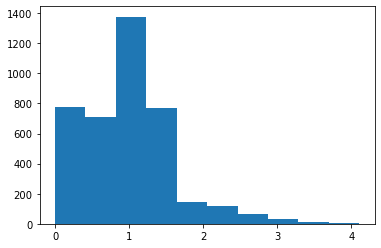

In [76]:
plt.hist([t[1] for t in getRedshiftsByTileID(330)], bins=10)

## By HEALPix

In [68]:
def getRedshiftsByHEALPix(healpix, z_min=-1.0, z_max=6.0, spectype=None, subtype=None, limit=None, start=None, end=None):
    """ 
    @Params: 
        healpix (INTEGER): ID of HEALpix to search for redshifts
    
    @Returns:
        z (LIST): List of 2-index Tuples (targetID, redshift) containing the targetIDs and associated 
                  redshifts for targets found in provided HEALpix.
                  
    >>> getRedshiftsByHEALPix(2152, z_min=0.5, z_max=1.0, limit=3)
    [(39628473198710603, 0.804205874112604), (39628478449979314, 0.560197170373784), (39628473202901028, 0.665799925748929)]
    
    """
    if (healpix < 1): # Set healpix bounds
        raise ValueError(f'HEALPix {healpix} is invalid')
    
    q = db.dbSession.query(db.Zpix.targetid, db.Zpix.z).filter(db.Zpix.healpix == healpix)
    
    if (q.first() is None):
        raise ValueError(f'HEALPix ID {healpix} was not found')
    
    q = filter_query(q, db.Zpix, z_min=z_min, z_max=z_max, spectype=spectype, subtype=subtype, limit=limit, start=start, end=end)
    
    zs = q.all()
    return zs    

(array([6., 5., 2., 4., 2., 1., 0., 0., 0., 2.]),
 array([-1.99569129e-03,  2.61041901e-01,  5.24079494e-01,  7.87117086e-01,
         1.05015468e+00,  1.31319227e+00,  1.57622986e+00,  1.83926746e+00,
         2.10230505e+00,  2.36534264e+00,  2.62838023e+00]),
 <BarContainer object of 10 artists>)

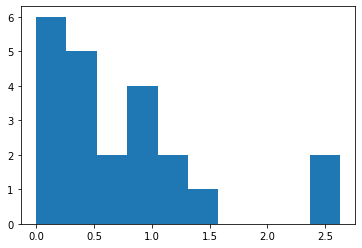

In [12]:
plt.hist([t[1] for t in getRedshiftsByHEALPix(2152, limit=1000)], bins=10)

## By RA and DEC

In [23]:
def getRedshiftsByRADEC(ra, dec, radius=0.01, z_min=-1.0, z_max=6.0, spectype=None, subtype=None, limit=None, start=None, end=None):
    """ 
    @Params: 
        ra (DOUBLE_PRECISION): Right Ascension of the center of cone to search for targets in degrees
        dec (DOUBLE_PRECISION): Declination of the center of cone to search for targets in degrees
        radius (DOUBLE_PRECISION): Radius of cone to search of targets in degrees
    
    @Returns:
        results (LIST): List of 4-indexed tuples containing (targetID, ra, dec, redshift) for targets found
                        in cone search of the provided ra, dec, radius
    
    >>> getRedshiftsByRADEC(178, 28, 0.2)
    [(39628438369209963, 178.20296293969, 28.0457875134468, -0.00199569129234795), (39628438369210160, 178.211062108015, 28.0054208609781, 1.55448584232623)]
    """
    if (ra > 360 or ra < 0):
        raise ValueError(f'Invalid Right Ascension {ra}')
    elif (dec > 90 or dec < -90):
        raise ValueError(f'Invalid Declination {dec}')
    elif (radius < 0):
        raise ValueError(f'Invalid Radius {radius}')
    
    q = db.dbSession.query(db.Photometry.targetid, db.Photometry.ra, db.Photometry.dec, db.Zpix.z)
    q = q.join(db.Zpix).filter(func.q3c_radial_query(db.Photometry.ra, db.Photometry.dec, ra, dec, radius))
    
    if (q.first() is None):
        raise ValueError(f'No objects found at RA {ra} and DEC {dec} within radius {radius}')
        
    q = filter_query(q, db.Zpix, z_min=z_min, z_max=z_max, spectype=spectype, subtype=subtype, limit=limit, start=start, end=end) 
    
    results = q.all()
    return results    

In [24]:
def plotRedshiftsByRADEC(ra, dec, vmin=None, vmax=None, cmap='RdBu_r', c=None, radius=0.1, z_min=-1.0, z_max=6.0, spectype=None, subtype=None, limit=None):
    results = getRedshiftsByRADEC(ra, dec, radius=radius, z_min=z_min, z_max=z_max, spectype=spectype, subtype=subtype, limit=limit)
    ra = []
    dec = []
    z = []
    count = 0
    for target in results:
        count += 1
        ra.append(target[1])
        dec.append(target[2])
        z.append(target[3])
    
    if c:
        c = list(map(c, z))
    else:
        c = z
        
    if vmin and vmax:
        fig = plt.scatter(x=ra, y=dec, c=c, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    elif vmin:
        fig = plt.scatter(x=ra, y=dec, c=c, cmap='RdBu_r', vmin=vmin)
    elif vmax:
        fig = plt.scatter(x=ra, y=dec, c=c, cmap='RdBu_r', vmax=vmax)
    else:
        fig = plt.scatter(x=ra, y=dec, c=c, cmap='RdBu_r')
        
    plt.colorbar(fig)
    plt.tight_layout()
    print(f'Found {count} targets')
    

Found 10 targets


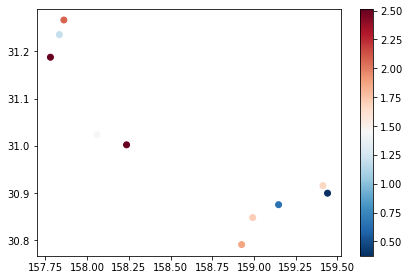

In [25]:
plotRedshiftsByRADEC(160, 30, radius=2.5, spectype='QSO', limit=10)

# Notes
- Redshift given in redshift units 1+z
- Need to make sure methods check in more tables incase targets are not in current table
- Add method to get portions of the query
- Add cache system for repeated queries

# Testing

In [17]:
import doctest

In [80]:
doctest.testmod(optionflags=doctest.ELLIPSIS)

TestResults(failed=0, attempted=11)

In [88]:
with open('TestAccessTests.txt', 'r') as file:
    tests = file.read()
dtp = doctest.DocTestParser()
globs = globals()
dt = dtp.get_doctest(string=tests, globs=globs, name="Test Access", filename="TestAccessTests.txt", lineno=None)
dtr = doctest.DocTestRunner(optionflags=doctest.ELLIPSIS)
dtr.run(dt)

TestResults(failed=0, attempted=16)

In [20]:
def SQLNumConvert(item):
    if item.find('.') != -1:
        return float(item)
    else:
        return int(item)

def convertSQLresponse(s):
    """
    @Params:
        s (String): SQL outptut string with vertical bar | seperators for columns and new lines \n for rows
    
    @Returns:
        None
    
    @Side Effects:
        -Prints rows of SQL query as list of tuples for each row.
    """
    items = list(filter(lambda x:x!='', s.split(' ')))
    rows = []
    row = []
    for item in items:
        if item.find('\n') != -1:
            item = SQLNumConvert(item)
            row.append(item)
            rows.append(tuple(row))
            row = []
        elif item != '|':
            row.append(SQLNumConvert(item))
    if row != []:
        rows.append(tuple(row))
    print(rows)
    

In [76]:
convertSQLresponse(
 """39628438369209963 |  178.20296293969 | 28.0457875134468 | -0.00199569129234795
 39628438369210160 | 178.211062108015 | 28.0054208609781 |     1.55448584232623""")

[(39628438369209963, 178.20296293969, 28.0457875134468, -0.00199569129234795), (39628438369210160, 178.211062108015, 28.0054208609781, 1.55448584232623)]
